# <font  color = "#0093AF"> $T_1$ limits

Longitudinal relaxation occurs because a relative fast motion—on the timescale of the lab frame rotation—induces a slow evolution of the density matrix. In this notebook, we check the validity of this lab frame calculation against analytical formulas, and also investigate the range in which equilibrium of the system to thermal equilibrium (via "DynamicThermal") is valid.

## SETUP

In [1]:
# SETUP SLEEPY
import os
os.chdir('../../../')

In [2]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt
# !git clone https://github.com/alsinmr/pyDR     #Uncomment on Google Colab to import pyDR. 
#pyDR will also install MDAnalysis
import pyDR

## Build the system

We mimick a tumbling motion by hopping around the 'rep10' power average. Note that tumbling is currently only implemented for colinear tensors without asymmetry (we don't include a gamma average, so this yield vector tumbling, not tensor tumbling).

In [3]:
# Since we use a tumbling model, we only need a single angle in the powder average
ex0=sl.ExpSys(v0H=400,Nucs=['15N','1H'],vr=0,LF=True,pwdavg='alpha0beta0')
ex0.set_inter('dipole',i0=0,i1=1,delta=22954.8)

# Set up tumbling
q=2
ex,kex=sl.Tools.SetupTumbling(ex0,q=q,tc=1e-9)  #This hops around the rep10 powder average

L=sl.Liouvillian(*ex,kex=kex)
L.add_relax('DynamicThermal')
seq=L.Sequence(Dt=.1)

We plot the full Liouvillian below, just to give an idea what the exchange looks like.

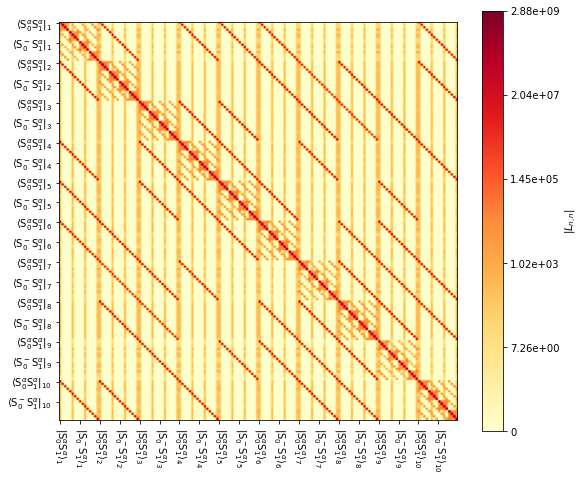

In [4]:
ax=L.plot()
ax.figure.set_size_inches([8,8])

## Sweep the correlation time
We don't use explicit propagation. Instead, we extract the decay rates using `rho.extract_decay_rates` to find the $T_1$ decay. We also calculate the signal at equilibrium. This is done by raising the density matrix to an infinite power (internally, we don't really use infinity- this just triggers an algorithm to calculate the equilibrium position)

In [5]:
tc0=np.logspace(-5,-13,20)
rho=sl.Rho('Thermal',['15Nz','1Hz'])
R1=[]
Ieq=[]
for tc in tc0:
    rho.clear()
    L.kex=sl.Tools.SetupTumbling(ex0,q=q,tc=tc)[1]
    U=seq.U()
    L.Udelta('15N')*(U**np.inf*rho)
    R1.append(rho.extract_decay_rates(U))
    L.Udelta('15N')*rho
    Ieq.append((rho)().I[:,0].real)

/Users/albertsmith/Documents/GitHub.nosync/SLEEPY/Rho.py:1623: RuntimeWarning: invalid value encountered in true_divide
  wt/=wt.sum()


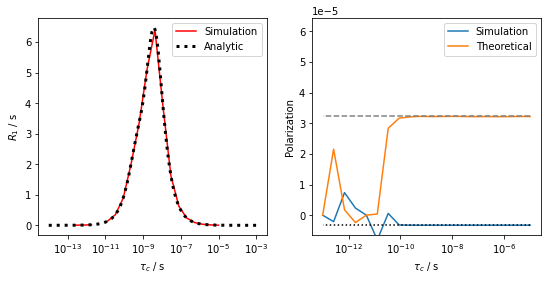

In [6]:
ax=plt.subplots(1,2,figsize=[9,4])[1]
ax[0].semilogx(tc0,R1,color='red')
nmr=pyDR.Sens.NMR(v0=400,Nuc='15N',CSA=0,Type='R1')
ax[0].semilogx(nmr.tc,nmr.rhoz.T*2,color='black',linestyle=':',linewidth=3)
ax[1].semilogx(tc0,np.array(Ieq))
ax[1].semilogx([tc0[0],tc0[-1]],ex0.Peq[0]*np.ones(2),linestyle=':',color='black')
ax[1].semilogx([tc0[0],tc0[-1]],ex0.Peq[1]*np.ones(2),linestyle='--',color='grey')
ax[1].set_ylim([ex0.Peq[0]*2,ex0.Peq[1]*2])

for a in ax:a.set_xlabel(r'$\tau_c$ / s')
ax[0].set_ylabel(r'$R_1$ / s')
ax[0].legend(('Simulation','Analytic'))
ax[1].set_ylabel('Polarization')
ax[1].legend(('Simulation','Theoretical'))

We see extremely good agreement between the simulation and the analytical formulas implemented in pyDR

(0.0, -5e-06)

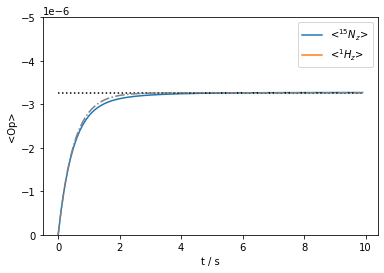

In [22]:
rho=sl.Rho('1Hz',['15Nz','1Hz'])
i=np.argmin(np.abs(nmr.tc-1e-9))
nmr.rhoz[0,i]
tc=nmr.tc[i]
R1=nmr.rhoz[0,i]
L.kex=sl.Tools.SetupTumbling(ex0,q=q,tc=tc)[1]
rho.DetProp(L.Sequence(Dt=0.1),n=100)
ax=rho.plot(axis='s')
ax.plot(rho.t_axis[[0,-1]],ex0.Peq[0]*np.ones(2),color='black',linestyle=':')
ax.plot(rho.t_axis[[0,-1]],ex0.Peq[1]*np.ones(2),color='grey',linestyle='--')
ax.plot(rho.t_axis,ex0.Peq[0]*(1-np.exp(-rho.t_axis*R1)),linestyle='-.',color='grey')
ax.set_ylim([0,-.5e-5])

In [21]:
R1

1.9859228585439819

In [9]:
nmr.tc[i]

9.437878277775391e-10

## Test "DynamicThermal" performance

SLEEPY contains a function to bring a system relaxed by exchange back into thermal equilibrium, obtained by running `L.add_relax('DynamicThermal')`. This is a somewhat artificial correction to obtain thermal equilibrium, and has a more limited application; this is because we have essentially very fast dynamics applied via `L.kex`, but then a correction that slowly brings magnetization back into the system. Small numerical errors can lead to large variation in the resulting equilibrium values.

We test this here as a function of correlation time. We do not recommend using 'DynamicThermal' with a large number of states in exchange.

In [13]:
ex0=sl.ExpSys(v0H=400,Nucs=['15N','1H'],vr=0,LF=True,pwdavg='alpha0beta0')
delta=sl.Tools.dipole_coupling(.102,'1H','15N')
ex0.set_inter('dipole',i0=0,i1=1,delta=22954.8)
ex1=ex0.copy().set_inter('dipole',i0=0,i1=1,delta=22954.8,euler=[0,np.pi/8,0])

L=sl.Liouvillian(ex0,ex1,kex=sl.Tools.twoSite_kex(1e-8))
L.add_relax('DynamicThermal')

seq=L.Sequence(Dt=.1)

rho=sl.Rho('Thermal',['15Nz','1Hz'])

In [14]:
tc0=np.logspace(-6,-12,80)
Ieq=[]
R1=[]
for tc in tc0:
    rho.clear()
    L.kex=sl.Tools.twoSite_kex(tc=tc)
    U=seq.U()
    R1.append(rho.extract_decay_rates(U))
    U=seq.U()
    Ieq.append((U**np.inf*rho)().I[:,0].real)

Ieq=np.array(Ieq)

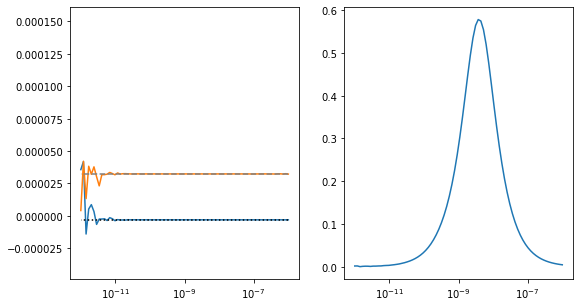

In [15]:
ax=plt.subplots(1,2,figsize=[9,5])[1]
ax[0].semilogx(tc0,Ieq)
ax[0].semilogx([tc0[0],tc0[-1]],np.ones(2)*ex0.Peq[0],color='black',linestyle=':')
ax[0].semilogx([tc0[0],tc0[-1]],np.ones(2)*ex0.Peq[1],color='grey',linestyle='--')
ax[0].set_ylim([ex0.Peq[0]*15,ex0.Peq[1]*5])
ax[1].semilogx(tc0,R1)

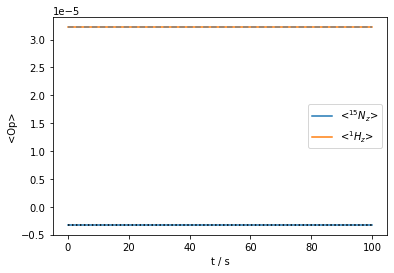

In [20]:
L.kex=sl.Tools.twoSite_kex(tc=5e-11)
# L.add_relax('DynamicThermal')
U=seq.U()
U=L.U(Dt=.1)
U.calcU()
rho=sl.Rho('zero',['15Nz','1Hz'])
(U**np.inf*rho).DetProp(U,n=1000)
ax=rho.plot(axis='s')
ax.plot([0,rho.t_axis[-1]],np.ones(2)*ex0.Peq[0],color='black',linestyle=':')
ax.plot([0,rho.t_axis[-1]],np.ones(2)*ex0.Peq[1],color='grey',linestyle='--')

In [72]:
U=L.U(Dt=100)
rho=sl.Rho('Thermal',['1Hz','15Nz'])
rho.L=L
np.abs((U[0]@U[0]@U[0]@rho._rho0[0])-rho._rho0[0]).max()
# (U*U*U*rho)().I

1.6856020504135705e-05

In [64]:
rho.

'Thermal'